In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import *


Discriminator model

In [3]:
input_shape = (28, 28, 1)

d_layers = (
    layers.Conv2D(64, (3,3), padding='same', input_shape=input_shape, strides=2),
    layers.LeakyReLU(),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3,3), padding='same', strides=2),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
)

discriminator = keras.Sequential(layers=d_layers, name='Discriminator')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Generator model

In [4]:
latent_dim = 100

g_layers = (
    layers.Dense(128*7*7, input_dim=latent_dim),
    layers.LeakyReLU(),
    layers.Reshape((7,7,128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Conv2D(1, 7, activation='sigmoid', padding='same')
)

generator=keras.Sequential(g_layers, name='Generator')
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

GAN model

In [5]:
discriminator.trainable = False
gan_layers = (
    generator,
    discriminator
)

gan = keras.Sequential(gan_layers, name='GAN')
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 28, 28, 1)         1164289   
                                                                 
 Discriminator (Sequential)  (None, 1)                 80769     
                                                                 
Total params: 1,245,058
Trainable params: 1,164,289
Non-trainable params: 80,769
_________________________________________________________________


Loading & handling data

In [6]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
Dataset = np.expand_dims(test_data, axis=-1)
Dataset = Dataset.astype('float32') / 255.0
print(Dataset.shape)

def generate_real_samples(batch_size):
  ix = np.random.randint(0, Dataset.shape[0], batch_size)
  X_real = Dataset[ix]
  Y_real = np.ones((batch_size, 1))
  return X_real, Y_real


def generate_fake_samples(generator, batch_size, latent_dim):
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  X_fake = generator.predict(random_latent_vectors)
  Y_fake = np.zeros((batch_size, 1))
  return X_fake, Y_fake



11490434/11490434 [==============================] - 0s 0us/step
(10000, 28, 28, 1)


Training model

In [13]:
epochs = 100
batch_size = 200
for i in range(epochs):
  for ii in range(int(Dataset.shape[0]/batch_size)):

    X_real, Y_real = generate_real_samples(batch_size)
    X_fake, Y_fake = generate_fake_samples(generator, batch_size, latent_dim)
    X, Y = np.vstack((X_real, X_fake)), np.vstack((Y_real, Y_fake))

    d_loss = discriminator.train_on_batch(X, Y)

    gan_input = np.random.normal(size=(batch_size, latent_dim))
    gan_labels = np.ones((batch_size, 1))

    gan_loss = gan.train_on_batch(gan_input, gan_labels)
    print(gan_loss, i)
  if i%5 == 0:
    print('EPOCH:5')





Выходные данные были обрезаны до нескольких последних строк (5000).
7/7 [==============================] - 0s 3ms/step
0.761491060256958 50
7/7 [==============================] - 0s 5ms/step
0.7061516642570496 50
7/7 [==============================] - 0s 4ms/step
0.7190796136856079 50
7/7 [==============================] - 0s 5ms/step
0.7106906771659851 50
7/7 [==============================] - 0s 3ms/step
0.7208470106124878 50
7/7 [==============================] - 0s 3ms/step
0.746792197227478 50
7/7 [==============================] - 0s 3ms/step
0.7137871384620667 50
7/7 [==============================] - 0s 5ms/step
0.8239911794662476 50
7/7 [==============================] - 0s 3ms/step
0.7600230574607849 50
7/7 [==============================] - 0s 4ms/step
0.6770933270454407 50
7/7 [==============================] - 0s 4ms/step
0.757760763168335 50
7/7 [==============================] - 0s 3ms/step
0.7224441766738892 50
7/7 [==============================] - 0s 5ms/step
0.719516

In [11]:
def draw_plot(examples, n):
 # plot images
 for i in range(n * n):
   plt.subplot(n, n, 1 + i)
   plt.axis('off')
   plt.imshow(examples[i, :, :, 0], cmap='gray')
 plt.show()

Results

1/1 [==============================] - 0s 23ms/step


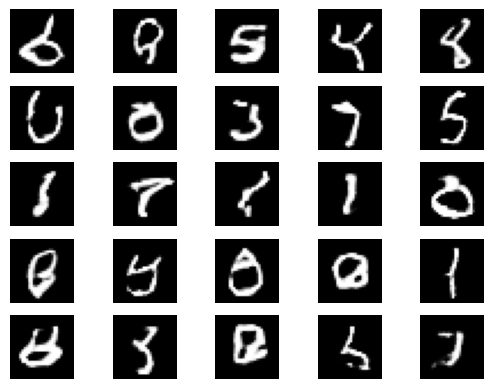

In [20]:
gan_input = np.random.normal(size=(25, 100))
x_plot = generator.predict(gan_input)

draw_plot(x_plot, 5)

Comparing with original dataset

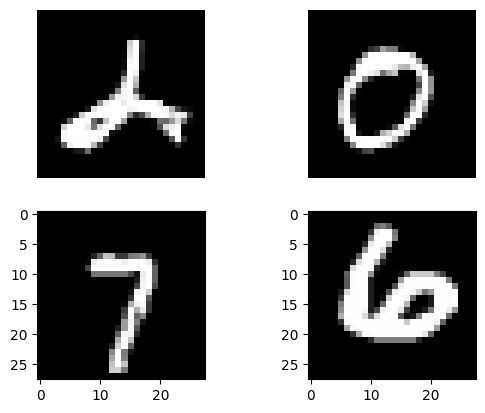

In [17]:
for i in [0,1]:
   plt.subplot(2, 2, 1 + i)
   plt.axis('off')
   plt.imshow(x_plot[i, :, :, 0], cmap='gray')
for i in [2,3]:
  plt.subplot(2, 2, 1 + i)
  plt.imshow(Dataset[np.random.randint(0, Dataset.shape[0]), :, :, 0], cmap='gray')
plt.show()